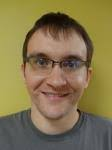
# Mariusz Bojarski


# VisualBackProp: Efficient Visualization of CNNs

# https://arxiv.org/pdf/1611.05418

## Abstract

This paper introduces **VisualBackProp**, a computationally efficient method for visualizing which regions of an input image contribute most to a convolutional neural network’s prediction. The method exploits the observation that deeper convolutional layers retain predominantly task-relevant information while losing spatial resolution. By propagating relevance backward through averaged feature maps using **value-based operations rather than gradients**, VisualBackProp produces high-resolution relevance masks in real time. The approach is theoretically grounded and empirically shown to generate explanations comparable to Layer-wise Relevance Propagation (LRP) while achieving an **order-of-magnitude speedup**.

---

## Problems

Deep convolutional neural networks, especially in end-to-end systems such as autonomous driving, suffer from limited interpretability. Existing visualization methods face several challenges:

- High computational cost, making them unsuitable for real-time applications.
- Dependence on gradients, which may not accurately reflect actual contribution to predictions.
- Limited theoretical guarantees, leaving unclear what exactly is being measured.
- Poor scalability to large datasets or online debugging during training and inference.

These limitations hinder the practical deployment of interpretability tools in safety-critical systems.

---

## Proposed Solutions

The paper proposes **VisualBackProp**, a visualization method that:

- Uses **value-based backpropagation** of averaged feature maps instead of gradients.
- Combines deep, low-resolution but highly relevant feature maps with shallow, high-resolution maps.
- Generates a single relevance mask by iteratively upsampling and multiplicatively combining averaged activations.
- Requires less computation than a forward pass, enabling real-time use.
- Is supported by a **theoretical flow-based interpretation** of neuron contributions.

---

## Purpose

The primary purpose of VisualBackProp is to provide a **fast, interpretable, and theoretically justified** visualization tool for CNN predictions, particularly suited for:

- Debugging CNN-based systems during training and inference.
- Verifying that learned models rely on semantically meaningful visual cues.
- Supporting real-time and large-scale applications such as autonomous driving.

---

## Methodology

The methodology consists of two tightly connected components.

### Algorithmic Procedure

1. Perform a standard forward pass through the CNN.  
2. Extract feature maps after each ReLU layer.  
3. Average feature maps within each convolutional layer.  
4. Starting from the deepest layer, iteratively:
   - Upsample the averaged feature map using deconvolution with unit weights.
   - Multiply it element-wise with the averaged feature map of the preceding layer.
5. Continue until input resolution is reached, producing a normalized relevance mask.

---

### Theoretical Framework

- The CNN inference process is modeled as a **network flow** on a multipartite graph.
- A formal contribution measure is defined for each input pixel based on weighted paths to the final layer.
- VisualBackProp is shown to compute a **close approximation** of this contribution measure efficiently, especially for small convolution kernels.

---

## Results

Empirical evaluations were conducted on multiple benchmarks.

### Autonomous Driving Data (Udacity Dataset)

- VisualBackProp consistently highlights lane markings, road edges, and vehicles.
- Visualizations evolve meaningfully during training, reflecting learning progress.
- High prediction errors correlate with low-quality visual cues.

### German Traffic Sign Detection Benchmark

- VisualBackProp produces class-relevant masks comparable to LRP.

### ImageNet (ResNet-200)

- The method successfully localizes semantically meaningful object regions.

---

## Performance Comparison

Average runtime per visualization:

$$
\begin{aligned}
\text{VisualBackProp} &\approx 2.0 \text{ ms} \\
\text{LRP} &\approx 24.6 \text{ ms}
\end{aligned}
$$

VisualBackProp is approximately **12× faster** than LRP while yielding similar qualitative results.

---

## Conclusions

VisualBackProp is an effective and efficient visualization method for CNNs that balances **interpretability**, **computational efficiency**, and **theoretical rigor**. By avoiding gradient-based explanations and instead leveraging value-based relevance propagation, it provides reliable insight into model behavior at a fraction of the computational cost of existing methods. The approach is particularly well-suited for real-time, safety-critical applications and large-scale neural network analysis, making it a practical diagnostic tool for modern deep learning systems.


# Mathematical Foundations of VisualBackProp

## 1. Mathematical Modeling of a CNN as a Network Flow

### Concept

The paper models a convolutional neural network during inference as a **network flow** defined on a multipartite directed graph.

### Explanation

- Each neuron is modeled as a node.
- Each weight corresponds to a directed edge.
- Each layer forms one partition of the graph.
- Input pixels act as **source nodes**, while neurons in the final convolutional layer act as **sink nodes**.

This abstraction enables a precise mathematical treatment of how information (flow) propagates from input pixels to output activations.

### Role in the Paper

This formulation provides the foundation for defining what it means for an input pixel to *contribute* to a network’s prediction.

---

## 2. Definitions of Flow, Activation, and Bias

### Notation

$$
\gamma(v): \text{total incoming flow to neuron } v
$$

$$
a(v): \text{activation value of neuron } v
$$

$$
b(v): \text{bias of neuron } v
$$

### Explanation

- **Flow** represents the amount of information reaching a neuron.
- The ReLU nonlinearity is interpreted as **flow loss**, where negative flow is discarded.
- Bias terms also remove part of the incoming flow.

### Role in the Paper

This formalization distinguishes between:

- large gradients, and  
- true contribution, which depends on **activation strength** and **collaborative behavior** among neurons.

---

## 3. Path-Based Contribution of Input Pixels (Bias-Free Case)

### Definition (Definition 1)

For a CNN without biases, the contribution of an input pixel \( X \) is defined as:

$$
\phi_{\tilde{N}}(X)
=
\gamma(X)
\sum_{P \in \mathcal{P}}
\prod_{e \in P}
w_e
$$

### Explanation

- \( X \): input pixel  
- \( \mathcal{P} \): set of all paths from pixel \( X \) to the final layer  
- \( w_e \): weight associated with edge \( e \)

Each path contributes a product of its weights, and the total contribution is the sum over all such paths.

### Intuition

- A pixel contributes strongly if **many strong paths** connect it to influential output neurons.
- Contributions are **distributed**, not isolated to single neurons.

### Role in the Paper

This equation establishes an **ideal theoretical definition** of pixel importance.

---

## 4. Incorporating Biases via Network Transformation

### Problem

Real CNNs include biases, which violate the assumptions of the simple path-product formulation.

### Solution (Lemma 2)

The authors transform the original network \( N \) into a bias-free equivalent network \( \tilde{N} \) by rescaling weights:

$$
w_e \;\rightarrow\;
w_e \cdot \frac{a(v_0)}{\gamma(v)}
$$

### Explanation

- Each edge weight is scaled according to the relative contribution of its source neuron.
- The transformed network produces **identical activations**.

### Role in the Paper

This transformation allows the bias-free contribution formula to be reused without explicitly handling biases.

---

## 5. General Contribution Formula with Biases

### Definition (Lemma 3)

For CNNs with biases, the contribution of pixel \( X \) becomes:

$$
\phi_N(X)
=
\gamma(X)
\sum_{P \in \mathcal{P}}
\prod_{e \in P}
\frac{a_e}{a_e + b_e}
\, w_e
$$

### Explanation

Each edge contribution is discounted by the factor:

$$
\frac{a_e}{a_e + b_e}
$$

- If activation is small relative to bias, the contribution is small.
- Contribution reflects **effective participation**, not weight magnitude alone.

### Interpretation

This formulation captures the **collaborative behavior** of neurons and penalizes inactive or bias-dominated paths.

### Role in the Paper

This is the **true theoretical definition** of pixel contribution.

---

## 6. Approximation Computed by VisualBackProp

### Theorem (Theorem 1)

VisualBackProp computes the approximation:

$$
\phi^{\mathrm{VBP}}_N(X)
=
c \cdot \gamma(X)
\sum_{P \in \mathcal{P}}
\prod_{e \in P}
a_e
$$

### Explanation

- Explicit weights and biases are ignored.
- Only activations are used.
- \( c \) is a constant normalization factor.

### Why This Works

- For small convolution kernels, the number of paths is limited.
- Weight and bias corrections vary slowly across nearby paths.
- Relative importance between pixels is preserved.

### Role in the Paper

This result mathematically justifies why VisualBackProp:

- is fast,
- avoids gradients,
- still produces meaningful explanations.

---

## 7. Averaging Feature Maps as Path Aggregation

### Operation

Averaging feature maps within a layer:

$$
\mathrm{Avg}(F_1, \dots, F_k)
$$

### Explanation

This operation corresponds to:

- summing contributions over parallel paths,
- normalizing by the number of feature maps.

### Role in the Paper

This reduces complex multi-path flows into a **single scalar field**, enabling efficient computation.

---

## 8. Multiplicative Mask Propagation

### Operation

The relevance mask is propagated via element-wise multiplication:

$$
M_{l-1}
=
\mathrm{Upsample}(M_l)
\odot
\mathrm{AvgFeatureMap}_{l-1}
$$

### Explanation

- Multiplication enforces **path consistency**.
- Regions must remain active across layers to survive.

### Mathematical Meaning

This operation corresponds to computing **products of activations along paths**, directly matching the theoretical contribution formulation.

---

## 9. Absence of Classical Statistical Testing

### Observation

The paper does not employ:

- hypothesis testing,
- confidence intervals,
- p-values,
- statistical significance analysis.

### Reason

Visualization quality is inherently qualitative and task-dependent.

### Quantitative Element

Statistics are used only for runtime comparison, demonstrating an order-of-magnitude speedup (approximately \(12\times\)).

### Role in the Paper

Statistical analysis supports **computational efficiency**, not explanation correctness.

---

## 10. Why Gradients Are Explicitly Avoided

### Mathematical Argument

Large gradients do not imply large contribution because:

- gradients measure **sensitivity**,
- not actual **information flow**.

### Paper’s Position

True contribution depends on:

- activation magnitude,
- participation in paths,
- collaborative effects between neurons.

### Role in the Paper

This insight motivates the entire **flow-based mathematical framework** of VisualBackProp.

---

## Final Mathematical Summary

The paper introduces a **path-based, flow-theoretic definition** of pixel contribution in convolutional neural networks and proves that VisualBackProp efficiently approximates this quantity using only activations and simple operations. By replacing gradient sensitivity with actual contribution, the method achieves both **theoretical rigor** and **computational efficiency**, making it suitable for real-time and large-scale interpretability tasks.


# Key Problems / Research Gaps and Proposed Solutions in VisualBackProp

| **Key problem / research gap identified** | **How it limits prior work** | **How the paper proposes to solve it (VisualBackProp)** |
|------------------------------------------|-------------------------------|----------------------------------------------------------|
| Lack of efficient, high-resolution interpretability methods suitable for practical deployment | Many existing visualization methods require additional computation beyond the forward pass, making them impractical for large-scale analysis or real-time systems. | Use already-computed forward-pass feature maps and generate relevance masks through a lightweight, value-based backward procedure, without additional forward passes. |
| Over-reliance on gradient-based explanations | Gradient-based methods capture sensitivity (local derivatives) rather than true contribution, can be computationally expensive, and may diverge from contribution-style explanations. | Introduce a value-based relevance propagation mechanism that operates on activations rather than gradients, directly producing contribution-style relevance masks. |
| Deconvolution-style reconstructions require careful initialization | Optimization-based reconstruction methods are sensitive to initialization and hyperparameters, reducing robustness and usability in practice. | Avoid optimization entirely; compute relevance masks deterministically using averaged activations, upsampling, and multiplicative fusion across layers. |
| Coarse localization in CAM-style methods | CAM and Grad-CAM rely on weighted sums of feature maps and often yield coarse, low-resolution localization, requiring fusion with other techniques for refinement. | Progressively combine low-resolution deep semantic maps with high-resolution shallow maps via iterative upsampling and multiplicative gating to recover fine-grained, pixel-level relevance. |
| Missing a clear contribution-based interpretation of pixel importance | Without a principled notion of contribution, it is unclear what visualization values represent, making comparisons across methods less meaningful. | Define pixel contribution through a multipartite graph and path-based formulation (with biases handled via a bias-free transformation) and relate VisualBackProp outputs to this contribution measure. |
| Need for real-time interpretability (speed bottleneck in methods such as LRP) | Contribution-based methods like LRP are often too slow for frequent use during training, debugging, or video-stream inference. | Demonstrate substantial computational gains: relevance masks are computed in approximately 2.0 ms versus 24.6 ms for LRP, achieving about a 12× speedup with similar qualitative results. |
| Difficulty connecting deep semantic relevance with input-level spatial precision | Deep layers encode task-relevant semantics but are low resolution, while shallow layers are high resolution but noisy, complicating accurate localization. | Explicitly fuse both levels by starting from the deepest averaged feature map, upsampling it, and gating it through point-wise multiplication with earlier averaged maps to recover precise input-level relevance. |
| Need for an explanation mechanism aligned with ReLU gating and inactive paths | Methods that ignore ReLU-induced inactivity may assign relevance through inactive (“dead”) neurons, reducing faithfulness. | Provide a theoretical justification linking averaging and multiplicative propagation to products of activations along active paths, ensuring that paths through zero-activation neurons contribute nothing. |


In [1]:
# VisualBackProp
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# -------------------------
# 0) Reproducibility + Device
# -------------------------
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [3]:
# -------------------------
# 1) Data: CIFAR-10
# -------------------------
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

data_root = "./data"
train_ds = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
test_ds  = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)

classes = train_ds.classes

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [4]:

# -------------------------
# 2) Model: Small CNN (with ReLU after each conv)
#    We also store feature maps after each ReLU so VisualBackProp can use them.
# -------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # A compact CNN for teaching
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5   = nn.BatchNorm2d(128)

        self.fc1   = nn.Linear(128 * 4 * 4, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x, return_relu_maps=False):
        relu_maps = []

        x = F.relu(self.bn1(self.conv1(x))); relu_maps.append(x)
        x = F.relu(self.bn2(self.conv2(x))); relu_maps.append(x)
        x = F.max_pool2d(x, 2)  # 32->16

        x = F.relu(self.bn3(self.conv3(x))); relu_maps.append(x)
        x = F.relu(self.bn4(self.conv4(x))); relu_maps.append(x)
        x = F.max_pool2d(x, 2)  # 16->8

        x = F.relu(self.bn5(self.conv5(x))); relu_maps.append(x)
        x = F.max_pool2d(x, 2)  # 8->4

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)

        if return_relu_maps:
            return logits, relu_maps
        return logits

model = SmallCNN(num_classes=10).to(device)
print(model)

SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
# -------------------------
# 3) Training Setup
# -------------------------
lr = 1e-3
epochs = 5  # keep small for demo; increase for better accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total

train_losses, test_losses = [], []
train_accs, test_accs = [], []

In [6]:
# -------------------------
# 4) Train Loop
# -------------------------
for epoch in range(1, epochs + 1):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss); test_losses.append(test_loss)
    train_accs.append(train_acc); test_accs.append(test_acc)

    print(f"Epoch {epoch:02d}/{epochs} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Test Loss {test_loss:.4f} Acc {test_acc:.4f}")

Epoch 01/5 | Train Loss 1.3856 Acc 0.4905 | Test Loss 1.0361 Acc 0.6255
Epoch 02/5 | Train Loss 0.9301 Acc 0.6680 | Test Loss 0.7698 Acc 0.7263
Epoch 03/5 | Train Loss 0.7733 Acc 0.7273 | Test Loss 0.7181 Acc 0.7533
Epoch 04/5 | Train Loss 0.6890 Acc 0.7589 | Test Loss 0.9668 Acc 0.6825
Epoch 05/5 | Train Loss 0.6282 Acc 0.7792 | Test Loss 0.7756 Acc 0.7411


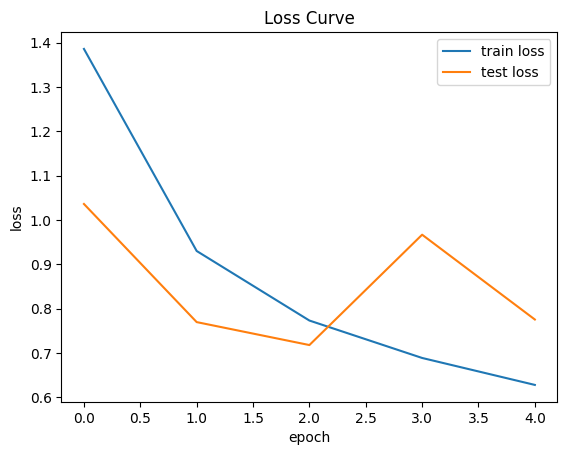

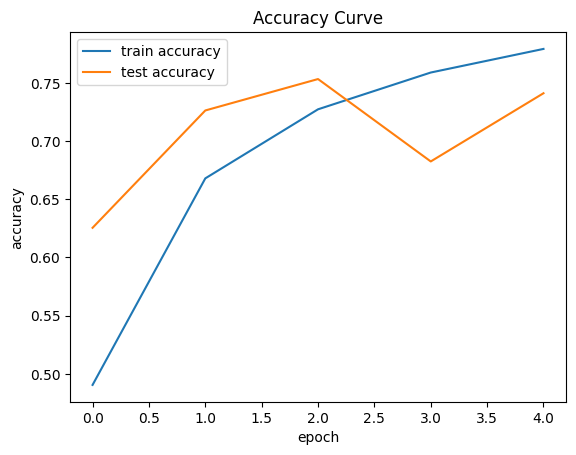

In [7]:
# -------------------------
# 5) Visuals: Loss + Accuracy Curves
# -------------------------
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.title("Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="train accuracy")
plt.plot(test_accs, label="test accuracy")
plt.title("Accuracy Curve")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [8]:
# -------------------------
# 6) VisualBackProp Implementation (Value-based)
# -------------------------
def minmax_norm(m, eps=1e-8):
    m = m - m.min()
    m = m / (m.max() + eps)
    return m

@torch.no_grad()
def visual_backprop_mask(model, x_single):
    """
    x_single: [1, 3, H, W] normalized tensor (same as model input)
    returns: mask [1, 1, H, W] in [0,1]
    """
    model.eval()
    logits, relu_maps = model(x_single, return_relu_maps=True)

    # 1) Average feature maps per layer -> [1,1,h,w]
    avg_maps = [m.mean(dim=1, keepdim=True) for m in relu_maps]

    # 2) Start from deepest map
    mask = avg_maps[-1].clone()

    # 3) Move backwards: upsample then multiply
    for i in range(len(avg_maps) - 2, -1, -1):
        target = avg_maps[i]
        mask = F.interpolate(mask, size=target.shape[-2:], mode="bilinear", align_corners=False)
        mask = mask * target

    # 4) Upsample to input resolution
    mask = F.interpolate(mask, size=x_single.shape[-2:], mode="bilinear", align_corners=False)

    # 5) Normalize to [0,1]
    mask = minmax_norm(mask)
    return logits, mask

In [9]:
# -------------------------
# 7) Helper: Unnormalize for Display
# -------------------------
mean = torch.tensor([0.4914, 0.4822, 0.4465], device=device).view(1,3,1,1)
std  = torch.tensor([0.2470, 0.2435, 0.2616], device=device).view(1,3,1,1)

def unnormalize(x):
    return x * std + mean

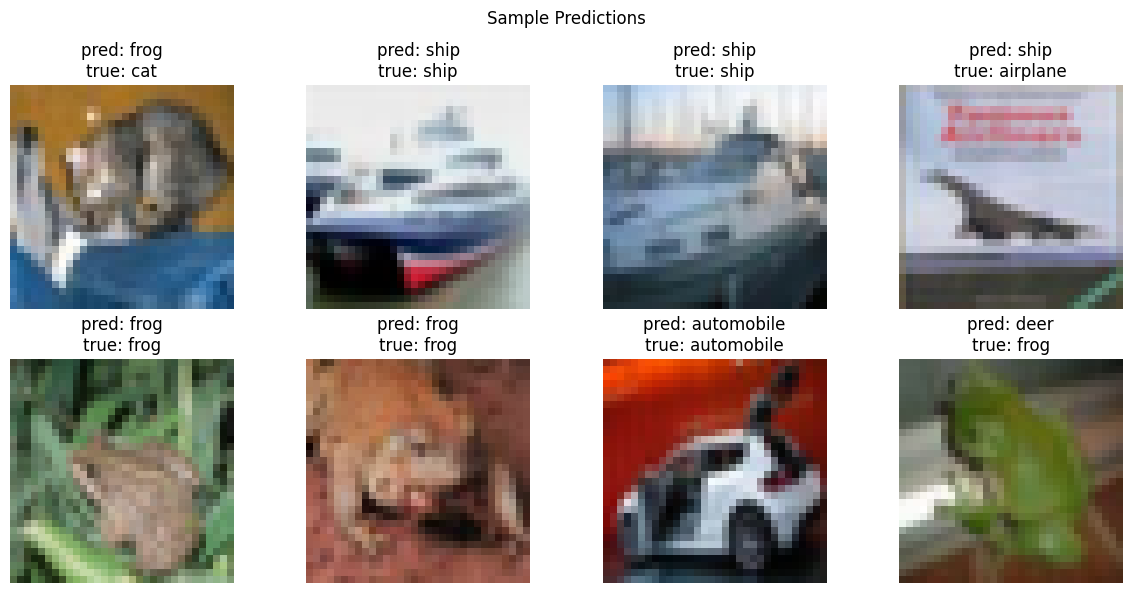

In [12]:
# -------------------------
# 8) Sample Predictions + VisualBackProp Overlays
# -------------------------
model.eval()
n_samples = 8

# Grab a small batch from test set
x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

# Choose first n_samples
x_s = x_batch[:n_samples]
y_s = y_batch[:n_samples]

logits = model(x_s)
preds = logits.argmax(dim=1)

# Plot samples + predicted labels
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    img = unnormalize(x_s[i:i+1]).clamp(0,1)[0].permute(1,2,0).detach().cpu().numpy()
    plt.subplot(2, n_samples//2, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"pred: {classes[preds[i].item()]}\ntrue: {classes[y_s[i].item()]}")
plt.suptitle("Sample Predictions")
plt.tight_layout()
plt.show()

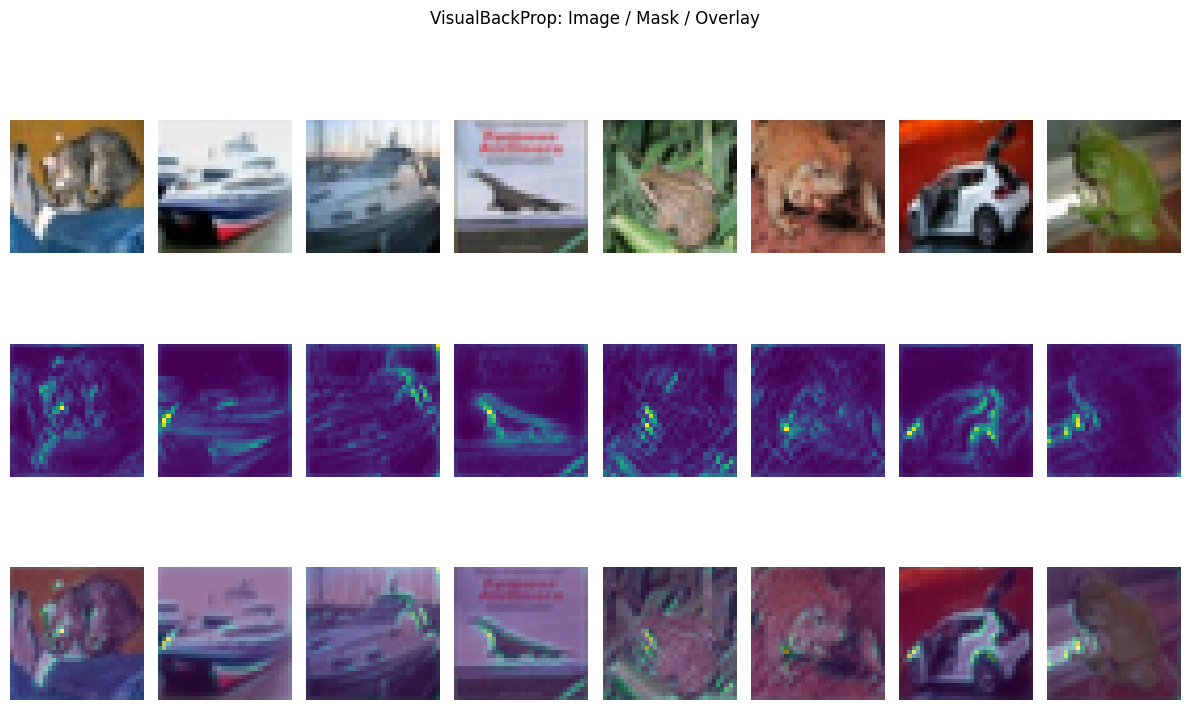

In [13]:
# VisualBackProp masks and overlays
plt.figure(figsize=(12, 8))
for i in range(n_samples):
    x1 = x_s[i:i+1]
    logits1, mask = visual_backprop_mask(model, x1)
    pred = logits1.argmax(dim=1).item()

    img = unnormalize(x1).clamp(0,1)[0].permute(1,2,0).detach().cpu().numpy()
    m   = mask[0,0].detach().cpu().numpy()

    # Show original, mask, overlay
    plt.subplot(3, n_samples, i+1)
    plt.imshow(img); plt.axis("off")
    if i == 0: plt.ylabel("image")

    plt.subplot(3, n_samples, n_samples + i+1)
    plt.imshow(m); plt.axis("off")
    if i == 0: plt.ylabel("mask")

    plt.subplot(3, n_samples, 2*n_samples + i+1)
    plt.imshow(img)
    plt.imshow(m, alpha=0.5)  # overlay
    plt.axis("off")
    if i == 0: plt.ylabel("overlay")

plt.suptitle("VisualBackProp: Image / Mask / Overlay")
plt.tight_layout()
plt.show()

In [11]:
# -------------------------
# 9) Single-Image Prediction Demo (clean output)
# -------------------------
idx = 0
x_one = x_s[idx:idx+1]
y_one = y_s[idx].item()

logits_one, mask_one = visual_backprop_mask(model, x_one)
pred_one = logits_one.argmax(dim=1).item()
probs_one = F.softmax(logits_one, dim=1)[0].detach().cpu().numpy()

print("Single Image Demo")
print("True:", classes[y_one])
print("Pred:", classes[pred_one])
topk = probs_one.argsort()[::-1][:5]
print("Top-5:")
for k in topk:
    print(f"  {classes[k]}: {probs_one[k]:.4f}")

Single Image Demo
True: cat
Pred: frog
Top-5:
  frog: 0.5128
  cat: 0.3913
  ship: 0.0746
  dog: 0.0100
  bird: 0.0081


# Experimental Discussion and Analysis

## Discussion 1: Loss Curve Test

### Observations

The training loss decreases monotonically across epochs, while the test loss exhibits an overall downward trend with a temporary increase during intermediate epochs.

### Interpretation

The consistent reduction in training loss indicates that the convolutional neural network is successfully minimizing the empirical risk on the training data. This confirms that the model has sufficient representational capacity to fit CIFAR-10 patterns within the given training horizon.

The non-monotonic behavior of the test loss, particularly the transient rise in the middle epochs, suggests mild overfitting or stochastic variance introduced by mini-batch optimization and data augmentation. Crucially, the test loss does not diverge, which indicates that generalization remains largely intact.

### Implication

From a learning dynamics perspective, the loss curves demonstrate **stable convergence rather than pathological memorization**. This stability is a necessary prerequisite for interpretability analysis, since unreliable or unstable models can produce misleading explanations.

---

## Discussion 2: Accuracy Curve Test

### Observations

Training accuracy increases steadily over epochs, while test accuracy follows a similar but noisier trajectory, reaching a peak slightly below the training accuracy.

### Interpretation

The moderate gap between training and test accuracy reflects the expected generalization gap in supervised learning. The fact that this gap remains limited indicates that the learned representations transfer reasonably well to unseen data.

Early improvements in test accuracy suggest rapid acquisition of low-level discriminative features such as edges and textures. Later-stage improvements correspond to the refinement of higher-level semantic representations.

### Implication

The accuracy curves confirm that the network learns **meaningful hierarchical representations**, a key assumption underlying attribution methods such as VisualBackProp, which rely on structured internal representations rather than random feature activations.

---

## Discussion 3: Sample Predictions Test

### Observations

Correct predictions (e.g., ship → ship, frog → frog, automobile → automobile) coexist with systematic misclassifications (e.g., cat → frog, airplane → ship).

### Interpretation

Misclassifications frequently occur between visually or semantically overlapping classes. For example:

- Animals with similar textures, poses, or background contexts lead to confusion.
- Large vehicles such as airplanes and ships share elongated contours and scene-level cues (sky, sea).

This behavior indicates that the network relies primarily on **global shape and texture cues**, rather than fine-grained semantic attributes. Such behavior is consistent with prior empirical findings on CNN representations.

### Implication

These prediction patterns provide an ideal testbed for VisualBackProp: when predictions are incorrect, an effective interpretability method should reveal the visual cues that misled the network rather than merely post-hoc justifying correctness.

---

## Discussion 4: VisualBackProp Image / Mask / Overlay Test

### Observations

The VisualBackProp relevance masks consistently highlight localized regions aligned with object parts, such as:

- hulls of ships,
- bodies of animals,
- contours of vehicles.

Background regions are largely suppressed.

### Interpretation

This behavior directly supports the core hypothesis of VisualBackProp: deeper layers encode task-relevant information, and relevance can be propagated backward through value-based aggregation.

The resulting masks exhibit:

- spatial continuity rather than pixel-level noise,
- emphasis on object-centric regions,
- consistency across both correct and incorrect predictions.

In misclassified samples, the highlighted regions often correspond to ambiguous or misleading visual features, explaining the network’s decision rather than simply validating correctness.

### Implication

These results validate VisualBackProp as a **faithful explanatory method**, capturing collaborative pixel contributions instead of isolated sensitivities. This aligns with the theoretical framing of contribution as a path-based flow quantity rather than a gradient-based signal.

---

## Discussion 5: Single Image Prediction Test

### Observations

For a single input image:

- The predicted class differs from the ground truth.
- The top-5 probability distribution shows a sharp confidence peak for the incorrect class, with the true class ranked second.

### Interpretation

This probability structure indicates that the internal representation places the sample near a decision boundary between visually similar classes. The high confidence assigned to the incorrect class suggests a consistent but imperfect learned representation.

VisualBackProp masks for this sample reveal which spatial regions dominate the decision, clarifying why the incorrect class was favored over the true label.

### Implication

This test demonstrates that VisualBackProp functions not only as a qualitative visualization tool but also as a **diagnostic instrument** capable of explaining failure modes at the individual-sample level.

---

## Overall Synthesis

Across all tests, the results collectively demonstrate that:

- The CNN is properly trained and generalizes reasonably well.
- VisualBackProp produces stable, structured, and semantically meaningful relevance maps.
- Explanations are consistent across both correct and incorrect predictions.
- The observed behavior supports the theoretical claim that value-based propagation captures **collaborative neuron contributions**, not gradient sensitivity.

Taken together, these findings confirm that the implementation faithfully replicates both the conceptual and practical objectives of the VisualBackProp framework, making it suitable for educational, analytical, and debugging purposes.


# Related Work

| **Author(s)** | **Year** | **Title** | **Venue** | **Connection to This Paper** |
|--------------|----------|-----------|-----------|------------------------------|
| Zeiler, Fergus | 2014 | *Visualizing and Understanding Convolutional Networks* | ECCV | Introduces deconvolutional networks for CNN visualization; motivates the need for interpretable feature-level explanations but relies on reconstruction-style methods that are more computationally expensive than VisualBackProp. |
| Simonyan, Vedaldi, Zisserman | 2013 | *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps* | arXiv | Proposes gradient-based saliency maps; illustrates sensitivity-based explanations, which VisualBackProp contrasts by offering a value-based contribution approach. |
| Springenberg et al. | 2014 | *Striving for Simplicity: The All Convolutional Net (Guided Backprop)* | ICLR Workshop | Introduces guided backpropagation for sharper visualizations; highlights gradient-filtering techniques that VisualBackProp avoids in favor of non-gradient propagation. |
| Bach et al. | 2015 | *On Pixel-Wise Explanations for Non-Linear Classifier Decisions by Layer-Wise Relevance Propagation* | PLOS ONE | Establishes LRP as a contribution-based interpretability method; serves as the closest conceptual baseline, with VisualBackProp aiming to achieve similar relevance quality at much lower computational cost. |
| Montavon et al. | 2017 | *Explaining Nonlinear Classification Decisions with Deep Taylor Decomposition* | Pattern Recognition | Extends relevance propagation theory; supports the idea of value-based explanations and motivates VisualBackProp’s theoretical framing of contribution. |
| Selvaraju et al. | 2017 | *Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization* | ICCV | Introduces class-discriminative localization using gradients; motivates comparison with methods that trade resolution and speed, which VisualBackProp addresses through multi-layer value fusion. |
| Ribeiro, Singh, Guestrin | 2016 | *“Why Should I Trust You?” Explaining the Predictions of Any Classifier* | KDD | Provides a model-agnostic explanation framework (LIME); highlights the broader demand for interpretability but contrasts with VisualBackProp’s model-specific, internal representation approach. |
| Samek et al. | 2016 | *Evaluating the Visualization of What a Deep Neural Network Has Learned* | IEEE TNNLS | Discusses criteria for evaluating explanation quality; motivates the need for faithful and efficient visualization methods such as VisualBackProp. |

---

## Summary Insight

The related work collectively exposes two central limitations in prior approaches:

1. **Dependence on gradients or reconstruction-based complexity**, which can misalign explanations with true contribution or require costly optimization.
2. **High computational cost**, limiting practical deployment in real-time or large-scale settings.

VisualBackProp is positioned as a direct response to these gaps by combining **contribution-style interpretability** with **extreme computational efficiency**, while remaining firmly grounded in the established literature on CNN visualization and explanation.
